In [1]:
import nltk
nltk.download('punkt')
import scipy as sc
from scipy.spatial.distance import cosine
import pandas as pd
import math
import logging
from collections import Counter
from  tqdm import tqdm
from tabulate import tabulate

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics

from tensorflow.keras.utils import to_categorical

import os
import re
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.sequence import pad_sequences
from keras import backend as k
from keras import initializers
from tensorflow.keras.optimizers import RMSprop,Adam,Adagrad
from keras.models import Model,Sequential,load_model
from keras.layers import Dense,LSTM,Input,Activation,Flatten,subtract,merge,concatenate,Reshape,Embedding,Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler,EarlyStopping


from google.colab import drive
drive.mount('/content/drive',force_remount=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


In [2]:
import threading
import numpy as np

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe"""
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def get_samples(x,y,batch_size,mode="train"):
    """One X generator"""
    sizeX = len(x)
    while True:
        try:
            index = [np.random.randint(0,sizeX) for k in range(batch_size)]
            examples=x[index]
            labels=y[index]
            yield (examples,labels)
        except Exception as e:
            print(e)
            break

@threadsafe_generator
def get_samples_2_inputs(x1,x2,y,batch_size,mode="train"):
    """Use this call in the case of Siamese networks with 2 X inputs"""
    sizeX = len(x1)
    while True:
        try:
            index = [np.random.randint(0,sizeX) for k in range(batch_size)]
            examples1=x1[index]
            examples2=x2[index]
            labels=y[index]
            yield [[examples1,examples2],labels]
        except Exception as e:
            print(e)
            break

In [3]:
train_data =  pd.read_csv('/content/drive/My Drive/thesis/feature_engineering/features_c.tsv', sep='\t', engine="python")

In [4]:
STRING_SIZE=16
BATCH_SIZE=64
NUM_EPOCHS = 16

In [5]:
data = train_data.filter(['q1_clean','q2_clean','annotation'], axis=1)

In [6]:
data = data.rename({'q1_clean': 'question1', 'q2_clean': 'question2' }, axis=1)

In [7]:
data.head()

,question1,question2,annotation
0,champion 120v gener want use plug preinstal wi...,120 240 dryer canada want use 240v countri,1
1,champion 120v gener want use plug preinstal wi...,power 220v neutral applianc 120v split phase,1
2,champion 120v gener want use plug preinstal wi...,possibl wire 240v outlet need 240v anymor two ...,1
3,run conduit contain 120v wire insid larger con...,advantag use emt plastic flexibl conduit low v...,0
4,run conduit contain 120v wire insid larger con...,cabl conduit use run new 240 volt line oven,1


In [8]:
def remove_special(text):
    special_chars = "[~#$%^@&*&()+-_\",?!.:[]\\;><`|{}=\\'=»¿シし]"
    for k in special_chars:
            if type(text) == str:
                if k=="-" or k=="_":
                    text=text.replace(k, "")
                else:
                    text=text.replace(k, " ")       
    return text

def contractions(sent):
    sub_pattern = [("will not","won't"),("shall not","shan't"),
                (" not", "n\'t"),(" will","\'ll"),(" is","\'s"),
                   (" am","\'m"),(" are","\'re"),(" is","who\'s")]
    sent2=sent.split(" ")
    hold = ""
    for k in range(len(sent2)):
        kk = sent2[k]
        for rep in range(len(sub_pattern)):
            kk = re.sub(sub_pattern[rep][1],sub_pattern[rep][0],kk)
        hold = hold + " " + kk
    return hold.lower()

def remove_stop_words(text):
    stops =  set(stopwords.words('english'))
    stops1 = [word.lower() for word in stops]
    punctuation = [',','.','!','?',';','-']
    hold = []
    if type(text) == list:
        for word in range(len(text)):
            if text[word].lower() in stops1 or text[word].lower() in punctuation or text[word].lower() == "xxxxxx":
                continue
            else:
                hold.append(text[word].lower())
    return hold

def wordTok(sent):
    tok = wt(sent)
    return tok

def pipeline(text):
    text = contractions(text)
    text = remove_special(text)
    textToks = wordTok(text)
    #textToks = remove_stop_words(textToks)
    final = ""
    for k in range(len(textToks)):
            final = final+textToks[k]+" "
    return final.strip().lower()

########################################################
########create corpus and create word vectors and training data###########
def createCorpus(t):
    corpus = []
    all_sent = []
    for k in t:
        for p in t[k]:
            corpus.append(st(p))
    for sent in range(len(corpus)):
        for k in corpus[sent]:
            all_sent.append(k)
    for m in range(len(all_sent)):
        all_sent[m] = wt(all_sent[m])
    
    all_words=[]
    for sent in all_sent:
        hold=[]
        for word in sent:
            hold.append(word.lower())
        all_words.append(hold)
    return all_words

def wordvecmatrix(model1,data):
    IO_data={"question1":[],"question2":[],"label":[]}
    pbar = tqdm(range(len(data["question1"])))
    for k in range(len(data["question1"])):
        q1=[]
        q2=[]
        label=[]
        for word in data["question1"][k]:
            try:
                q1.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        for word in data["question2"][k]:
            try:
                q2.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        IO_data["label"].append(data["annotation"][k])
        IO_data["question1"].append(q1) 
        IO_data["question2"].append(q2)
        pbar.update(1)
    print('\007')
    pbar.close()
    return IO_data

def sequence_padding(stringlist):
    newstring = pad_sequences(stringlist, maxlen=STRING_SIZE,
                              dtype=object,padding='post',value="PAD")
    return newstring

def list2string(listinput):
    hold=""
    for k in listinput:
        hold = hold +k.strip()+" "
    return hold.strip()

In [9]:
sentences1 = list(map(wordTok,data["question1"]))
sentences2 = list(map(wordTok,data["question2"]))

####Truncade and Pad to N words max
sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

data["question1"] = sentences1
data["question2"] = sentences2
dataAll = [data["question1"],data["question2"]] 
dataAll = pd.concat(dataAll)

In [10]:
model1 = Word2Vec(size = 256,sg=1,compute_loss=False,window=4,
                 min_count=1,workers=8)
model1.build_vocab(dataAll)  # prepare the model vocabulary
model1.train(dataAll, total_examples=model1.corpus_count,queue_factor=6, epochs=40)
model1.save("word2vec_256.model")
final_data = wordvecmatrix(model1,data)
print(sentences1[2])
print(len(final_data["question1"][2]))
print(sentences2[2])
print(len(final_data["question2"][2]))
del dataAll

100%|██████████| 8299/8299 [00:00<00:00, 15073.73it/s]


['champion', '120v', 'gener', 'want', 'use', 'plug', 'preinstal', 'wire', '240volt', 'split', 'phase', 'outlet', 'PAD', 'PAD', 'PAD', 'PAD']
16
['possibl', 'wire', '240v', 'outlet', 'need', '240v', 'anymor', 'two', '120v', 'circuit', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
16


In [11]:
y=final_data["label"]
categorical_labels = to_categorical(y,num_classes=3)
x1_train,x1_val,x2_train,x2_val,y_train,y_val = tts(final_data["question1"],
                                                    final_data["question2"],
                                                    y,test_size=0.2)

x1_train = np.array(x1_train,dtype='float32')
x1_val = np.array(x1_val,dtype='float32')
x2_train = np.array(x2_train,dtype='float32')
x2_val = np.array(x2_val,dtype='float32')
y_train = np.array(y_train,dtype='float32')
y_val = np.array(y_val,dtype='float32')


In [12]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [13]:
model1_input = Input(shape=(x1_train.shape[1],x1_train.shape[2]),name="input1")
model1_LSTM = LSTM(128,return_sequences=False,activation='relu',
                   dropout=0.45,recurrent_dropout=0.1,name="LSTM1")(model1_input)
model1 = Model(model1_input,model1_LSTM)

model2_input = Input(shape=(x2_train.shape[1],x2_train.shape[2]),name='input2')
model2_LSTM = LSTM(128,return_sequences=False,activation='relu',
                   dropout=0.45,recurrent_dropout=0.1,name="LSTM2")(model2_input)
model2 = Model(model2_input,model2_LSTM)

merged = subtract([model1_LSTM,model2_LSTM],name="merge")
#model_merged_LSTM = LSTM(64,return_sequences=False,activation='relu',dropout=0.4,recurrent_dropout=0.1,name="LSTM_merge")(merged)
Dense_merged1 = Dense(64,activation="relu",name="dense1")(merged)
model_merged_out = Dense(3,activation="softmax",name="output")(Dense_merged1)
model=Model([model1_input,model2_input],model_merged_out)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.998)
model.compile(adam, loss ='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 16, 256)]    0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 16, 256)]    0           []                               
                                                                                                  
 LSTM1 (LSTM)                   (None, 128)          197120      ['input1[0][0]']                 
                                                                                                  
 LSTM2 (LSTM)                   (None, 128)          197120      ['input2[0][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)
callbacks_list = [lrate,earlystopper]
model.fit([x1_train[:400],x2_train[:400]], y_train[:400],
          epochs=1,
          verbose=1,
          batch_size=32,
          validation_split=0.15,
          callbacks=callbacks_list)

11/11 [==============================] - 7s 177ms/step - loss: 1.1025 - accuracy: 0.4235 - val_loss: 1.0961 - val_accuracy: 0.4000 - lr: 0.0010


In [15]:
gentrain = get_samples_2_inputs(x1_train,x2_train,y_train,batch_size=BATCH_SIZE)
gentest = get_samples_2_inputs(x1_val,x2_val,y_val,BATCH_SIZE)
TRAIN_SIZE = len(x1_train)
VAL_SIZE = len(x1_val)
history = model.fit(gentrain, 
                     steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                     verbose=1,
                     validation_data=gentest,
                     validation_steps=VAL_SIZE//BATCH_SIZE,
                     epochs=NUM_EPOCHS,
                     workers=8,
                     use_multiprocessing=False,
                     callbacks=callbacks_list)

Epoch 1/16
103/103 [==============================] - 20s 163ms/step - loss: 1.0773 - accuracy: 0.4298 - val_loss: 1.0727 - val_accuracy: 0.4244 - lr: 0.0010
Epoch 2/16
103/103 [==============================] - 18s 178ms/step - loss: 1.0633 - accuracy: 0.4311 - val_loss: 1.0639 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 3/16
103/103 [==============================] - 16s 159ms/step - loss: 1.0417 - accuracy: 0.4539 - val_loss: 1.0573 - val_accuracy: 0.4431 - lr: 5.0000e-04
Epoch 4/16
103/103 [==============================] - 16s 160ms/step - loss: 1.0317 - accuracy: 0.4642 - val_loss: 1.0501 - val_accuracy: 0.4487 - lr: 5.0000e-04
Epoch 5/16
103/103 [==============================] - 17s 161ms/step - loss: 1.0226 - accuracy: 0.4763 - val_loss: 1.0527 - val_accuracy: 0.4144 - lr: 5.0000e-04
Epoch 6/16
103/103 [==============================] - 16s 157ms/step - loss: 1.0128 - accuracy: 0.4738 - val_loss: 1.0412 - val_accuracy: 0.4381 - lr: 2.5000e-04
Epoch 7/16
103/103 [================

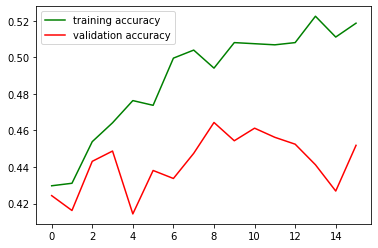

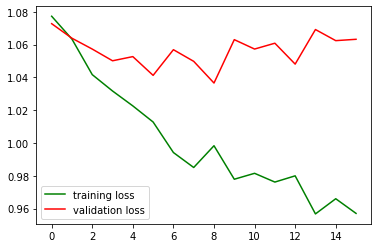

In [16]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

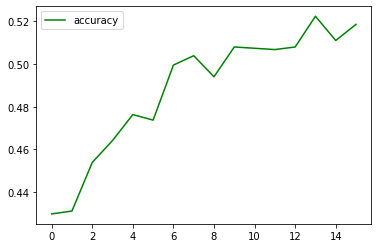

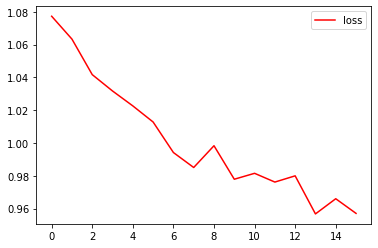

In [17]:
#plot 
plt.plot(accuracy,'g',label='accuracy')
plt.legend()
plt.show()

plt.plot(loss, 'r', label="loss")
plt.legend()
plt.show()

In [18]:
x_val = [x1_val,x2_val]

predi = np.array([])

preds = model.predict(x_val)

for i in range(len(preds)):
  if preds[i][0] > preds[i][1] and preds[i][0] > preds[i][2]:
    predi=np.append(predi, [0])
  elif preds[i][1] > preds[i][0] and preds[i][1] > preds[i][2]:
    predi=np.append(predi, [1])
  else:
    predi=np.append(predi, [2])

print(classification_report(y_val,predi))

              precision    recall  f1-score   support

         0.0       0.45      0.38      0.41       520
         1.0       0.46      0.69      0.55       698
         2.0       0.37      0.15      0.21       442

    accuracy                           0.45      1660
   macro avg       0.43      0.41      0.39      1660
weighted avg       0.43      0.45      0.42      1660



In [19]:
print("Accuracy:",metrics.accuracy_score(y_val, predi))
print("")
print("Precision-mac:",metrics.precision_score(y_val, predi, average='macro'))
print("Precision-w:",metrics.precision_score(y_val, predi, average='weighted'))
print("Recall-mac:",metrics.recall_score(y_val, predi, average='macro'))
print("Recall-w:",metrics.recall_score(y_val, predi, average='weighted'))
print("F1 Score-mac:",metrics.f1_score(y_val, predi, average='macro'))
print("F1 Score-w:",metrics.f1_score(y_val, predi, average='weighted'))

Accuracy: 0.4475903614457831

Precision-mac: 0.4272394009703544
Precision-w: 0.4332109208178248
Recall-mac: 0.4050055750755228
Recall-w: 0.4475903614457831
F1 Score-mac: 0.39105766304749845
F1 Score-w: 0.4166978483656875
